In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostClassifier, CatBoostRegressor

from mofapy2.run.entry_point import entry_point
import h5py

import sys
sys.path.append("..")

from src.tcga_preprocess_utils import handle_duplicates, prepare_data, choose_common_patients
from src.mofa_utils import transform_df_for_mofa, preprocess_data_for_mofa, train_mofa

In [2]:
RANDOM_STATE = 42

Выживаемость:

In [3]:
survival_data = pd.read_csv('data/breast/survival', sep='\t')
survival_data['PatientID'] = survival_data['PatientID'].str.lower()

survival_data = handle_duplicates(survival_data)
survival_data = survival_data.dropna(subset=['Death'])
survival_data = survival_data.set_index('PatientID')

survival_data

,Survival,Death
PatientID,,
tcga.ol.a66h,812.0,0.0
tcga.3c.aalk,1448.0,0.0
tcga.ar.a1ah,3807.0,0.0
tcga.ac.a5eh,511.0,0.0
tcga.ew.a2fw,672.0,0.0
...,...,...
tcga.e9.a3ho,1158.0,0.0
tcga.d8.a27e,530.0,0.0
tcga.ar.a24q,3172.0,0.0


In [4]:
expression_data = prepare_data('data/breast/exp', survival_data.index)
expression_data = preprocess_data_for_mofa(expression_data)

methylation_data = prepare_data('data/breast/methy', survival_data.index)
methylation_data = preprocess_data_for_mofa(methylation_data)

mirna_data = prepare_data('data/breast/mirna', survival_data.index)
mirna_data = preprocess_data_for_mofa(mirna_data)

*Теперь во всех оставляем только пациентов, встречающихся во всех 4х датасетах*

In [5]:
survival_data, expression_data, methylation_data, mirna_data = choose_common_patients(
    survival_data, expression_data, methylation_data, mirna_data)


target_death= survival_data['Death']
target_survival = survival_data['Survival']

In [6]:
print('Всего пациентов: ', expression_data.shape[0])

Всего пациентов:  620


MOFA

Преобразовываем под нужный формат данных, нормализуем

In [7]:
transformed_expression_data = transform_df_for_mofa(expression_data.copy(), 'DNA')
transformed_methylation_data = transform_df_for_mofa(methylation_data.copy(), 'Methylation')
transformed_mirna_data = transform_df_for_mofa(mirna_data.copy(), 'RNA')

combined_data = pd.concat([transformed_expression_data, transformed_methylation_data, transformed_mirna_data], axis=0)

scaler = MinMaxScaler()
combined_data['value'] = scaler.fit_transform(combined_data[['value']])


combined_data

,sample,feature,value,view
0,tcga.3c.aaau,?|10357,0.059777,DNA
1,tcga.3c.aali,?|10357,0.067703,DNA
2,tcga.3c.aalj,?|10357,0.105768,DNA
3,tcga.3c.aalk,?|10357,0.101071,DNA
4,tcga.4h.aaak,?|10357,0.074213,DNA
...,...,...,...,...
112835,tcga.wt.ab44,hsa-mir-99a,0.098390,RNA
112836,tcga.xx.a899,hsa-mir-99a,0.125517,RNA
112837,tcga.xx.a89a,hsa-mir-99a,0.105323,RNA
112838,tcga.z7.a8r5,hsa-mir-99a,0.099055,RNA


Обучаем модель

In [8]:
factors, weights, r2 = train_mofa(combined_data.copy(), RANDOM_STATE)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='DNA' with N=620 samples and D=1281 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1149 features...
Loaded group='single_group' view='RNA' with N=620 samples and D=182 features...


Model options:
- Automatic Relevan

Посмотрим как хорошо различаются факторы

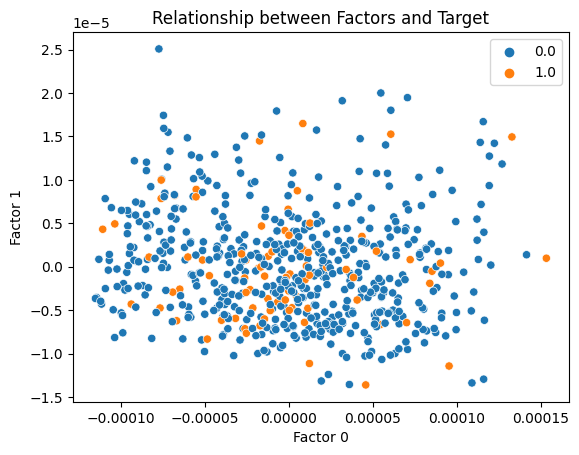

In [9]:
sns.scatterplot(x=factors[:, 0], y= factors[:, 1], hue=target_death.values)
plt.title('Relationship between Factors and Target')
plt.xlabel('Factor 0')
plt.ylabel('Factor 1');

Посмотрим можно ли предсказать смерть с помощью факторов

In [10]:
X_train, X_test, y_train, y_test = train_test_split(factors, target_death, test_size=0.25, random_state=RANDOM_STATE, stratify=target_death)

In [11]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.8709677419354839, F1: 0.0


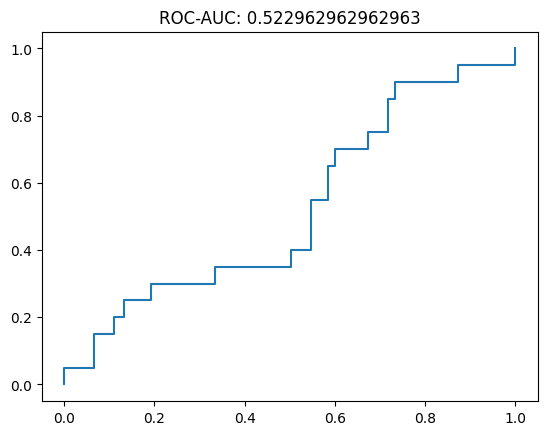

In [13]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {roc_auc}');

Топ генов по весам факторов

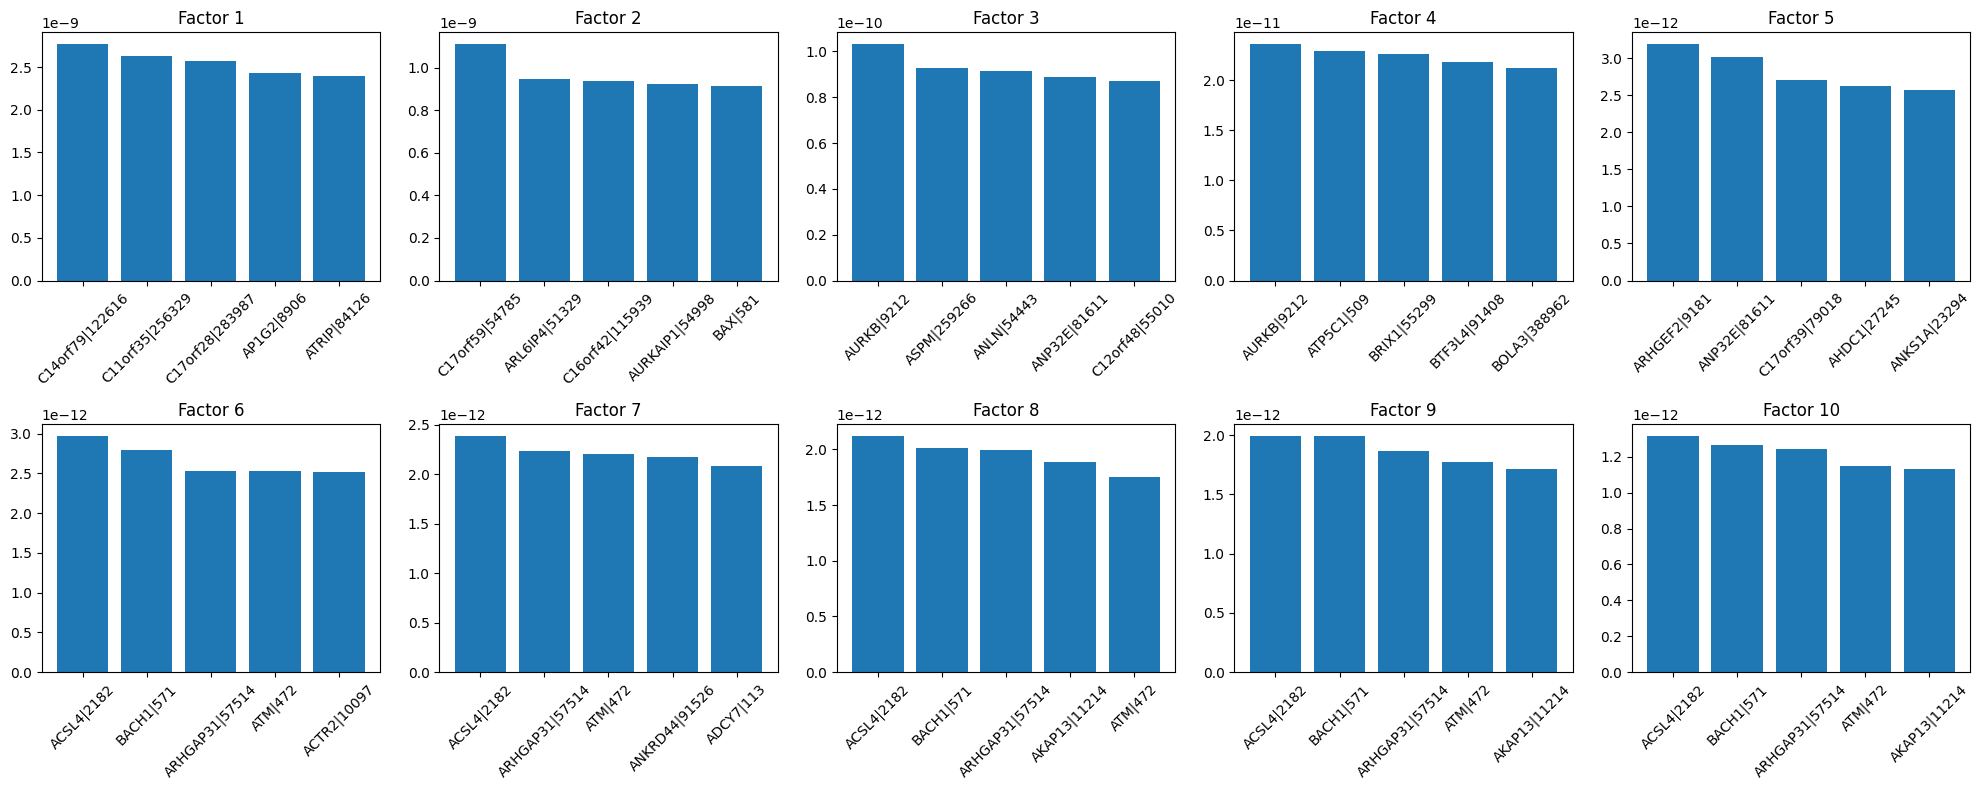

In [14]:
top_5_values = {}
top_5_indices = {}

for factor_idx in range(weights[0].shape[1]):
    top_indices = np.argsort(weights[0][:, factor_idx])[-5:][::-1] 
    top_values = weights[0][top_indices, factor_idx]
    top_5_values[factor_idx] = top_values
    top_5_indices[factor_idx] = expression_data.columns[top_indices]

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for i in range(10):
    axs[i].bar(top_5_indices[i], top_5_values[i])
    axs[i].set_title(f'Factor {i+1}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout();

In [15]:
top_5_indices

{0: Index(['C14orf79|122616', 'C11orf35|256329', 'C17orf28|283987', 'AP1G2|8906',
        'ATRIP|84126'],
       dtype='object'),
 1: Index(['C17orf59|54785', 'ARL6IP4|51329', 'C16orf42|115939', 'AURKAIP1|54998',
        'BAX|581'],
       dtype='object'),
 2: Index(['AURKB|9212', 'ASPM|259266', 'ANLN|54443', 'ANP32E|81611',
        'C12orf48|55010'],
       dtype='object'),
 3: Index(['AURKB|9212', 'ATP5C1|509', 'BRIX1|55299', 'BTF3L4|91408',
        'BOLA3|388962'],
       dtype='object'),
 4: Index(['ARHGEF2|9181', 'ANP32E|81611', 'C17orf39|79018', 'AHDC1|27245',
        'ANKS1A|23294'],
       dtype='object'),
 5: Index(['ACSL4|2182', 'BACH1|571', 'ARHGAP31|57514', 'ATM|472', 'ACTR2|10097'], dtype='object'),
 6: Index(['ACSL4|2182', 'ARHGAP31|57514', 'ATM|472', 'ANKRD44|91526',
        'ADCY7|113'],
       dtype='object'),
 7: Index(['ACSL4|2182', 'BACH1|571', 'ARHGAP31|57514', 'AKAP13|11214', 'ATM|472'], dtype='object'),
 8: Index(['ACSL4|2182', 'BACH1|571', 'ARHGAP31|57514', 'ATM

Используем Death как модальность

In [55]:
target_death.index.name = None

transformed_target_death = transform_df_for_mofa(pd.DataFrame(target_death.copy()), 'Death')

combined_data_death = pd.concat([combined_data, transformed_target_death], axis=0)

scaler = MinMaxScaler()
combined_data_death['value'] = scaler.fit_transform(combined_data_death[['value']])

combined_data_death

,sample,feature,value,view
0,tcga.3c.aaau,?|10357,0.059777,DNA
1,tcga.3c.aali,?|10357,0.067703,DNA
2,tcga.3c.aalj,?|10357,0.105768,DNA
3,tcga.3c.aalk,?|10357,0.101071,DNA
4,tcga.4h.aaak,?|10357,0.074213,DNA
...,...,...,...,...
615,tcga.c8.a8hr,Death,0.000000,Death
616,tcga.ar.a1ax,Death,0.000000,Death
617,tcga.d8.a27e,Death,0.000000,Death
618,tcga.ar.a24q,Death,0.000000,Death


In [56]:
factors_with_death, weights_with_death, r2_with_death = train_mofa(combined_data_death.copy(), RANDOM_STATE)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='DNA' with N=620 samples and D=1281 features...
Loaded group='single_group' view='Death' with N=620 samples and D=1 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1149 features...
Loaded group='single_group' view='RN

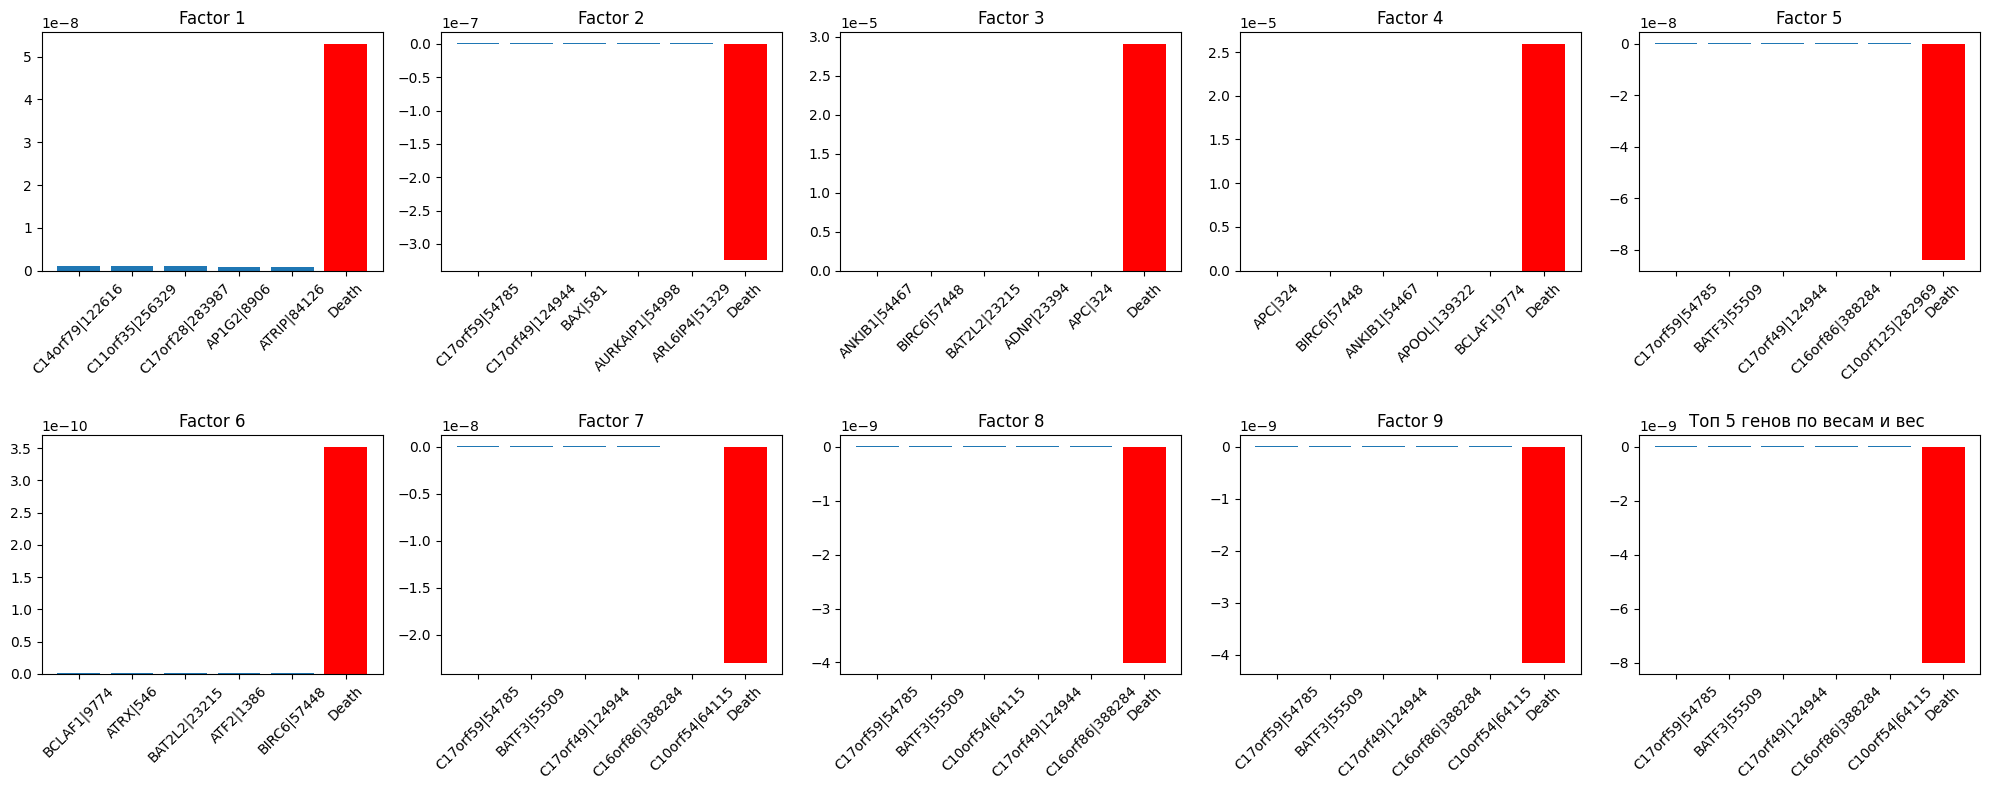

In [57]:
top_5_values = {}
top_5_indices = {}

for factor_idx in range(weights_with_death[0].shape[1]):
    top_indices = np.argsort(weights_with_death[0][:, factor_idx])[-5:][::-1] 
    top_values = weights_with_death[0][top_indices, factor_idx]
    top_5_values[factor_idx] = top_values
    top_5_indices[factor_idx] = expression_data.columns[top_indices]

    death_weight = weights_with_death[1][0][factor_idx]
    top_5_values[factor_idx] = np.concatenate([top_5_values[factor_idx], [death_weight]])
    top_5_indices[factor_idx] = np.concatenate([top_5_indices[factor_idx], ['Death']])

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for i in range(10):
    axs[i].bar(top_5_indices[i][:-1], top_5_values[i][:-1])
    axs[i].bar(top_5_indices[i][-1], top_5_values[i][-1], color='red')

    axs[i].set_title(f'Factor {i+1}')
    axs[i].tick_params(axis='x', rotation=45)

plt.title('Топ 5 генов по весам и вес ')
plt.tight_layout();

Просто максимальные веса факторов

In [86]:
max_weights = []

for i in range(4):
    modality_weights = weights_with_death[i]
    max_mod_weights = np.max(modality_weights, axis=0)
    max_weights.append(max_mod_weights)

max_weights = np.vstack(max_weights)

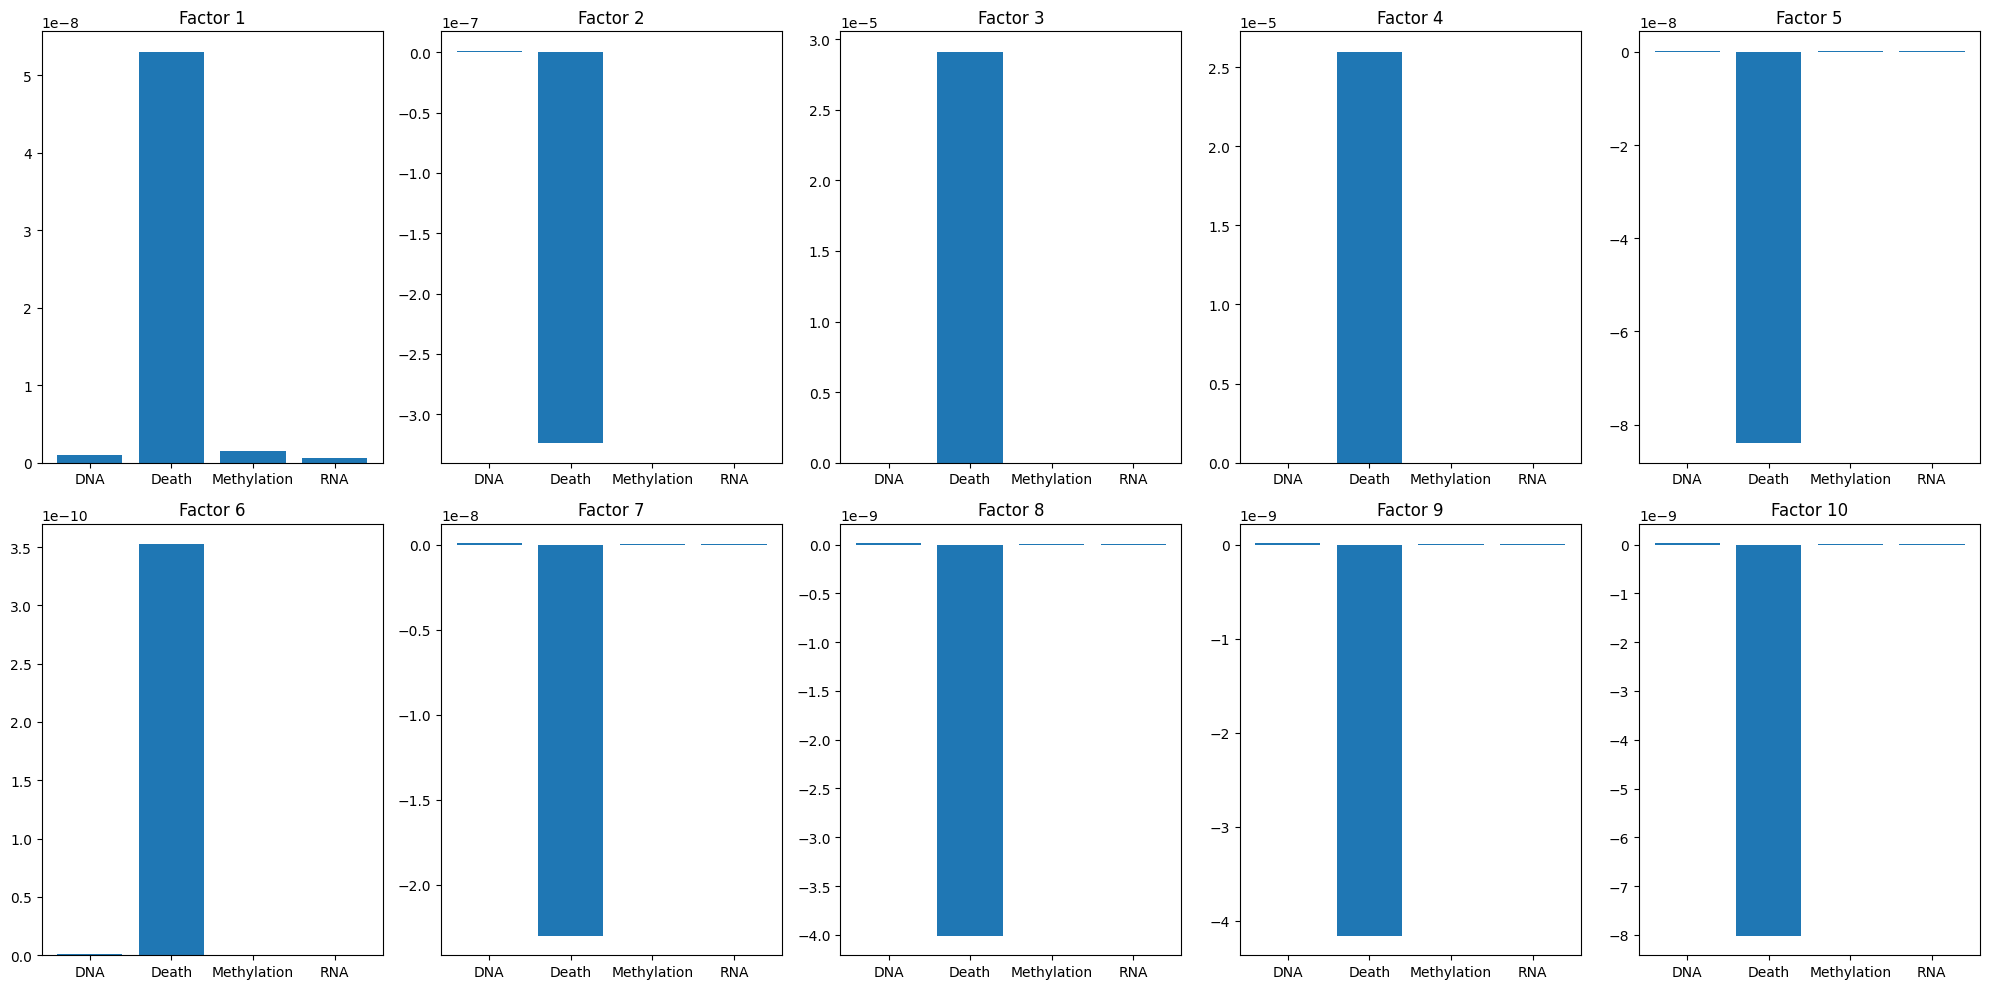

In [96]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for i in range(10):
    axs[i].bar(range(1, 5), max_weights[:, i])
    axs[i].set_title(f'Factor {i+1}')
    axs[i].set_xticks(range(1, 5))
    axs[i].set_xticklabels(['DNA', 'Death', 'Methylation', 'RNA'],)

plt.tight_layout();